# Load Variables

In [1]:
# Set environment variables

import os
from dotenv import load_dotenv

load_dotenv("./../credentials_my.env")

os.environ["AZURE_OPENAI_ENDPOINT"] = os.environ["AZURE_OPENAI_ENDPOINT_SCUS"]
os.environ["AZURE_OPENAI_API_KEY"]  = os.environ["AZURE_OPENAI_API_KEY_SCUS"]
os.environ["OPENAI_API_VERSION"]    = os.environ["AZURE_OPENAI_API_VERSION"]
os.environ["AZURE_OPENAI_API_TYPE"] = os.environ["OPENAI_API_TYPE"]

MODEL = os.environ["GPT4-0125PREVIEW-128k"]

# https://smith.langchain.com/
os.environ["LANGCHAIN_TRACING_V2"]  = "false"
os.environ["LANGCHAIN_PROJECT"]     = "langgraph_02 Custom Agents"
os.environ["LANGCHAIN_API_KEY"]     = os.environ["LANGCHAIN_API_KEY"]

question_basic                      = "What's the date of Easter 2021?"
question_for_tools                  = "My name is Mauro. What do I get, if I apply the magic tool to the number of characters of my name?"
question_follow_up                  = "Is this result an even or odd number?"

# ChatPromptTemplate
In this case we use a single variable:
- `input` should be a string containing the user objective.

In [2]:
# Create the ChatPromptTemplate

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

cpt = ChatPromptTemplate.from_messages(
    [    
        ("system", "Your name is Carl, you are very powerful assistant, but don't know current events"),
        ("user", "{input}")
    ]
)

cpt

ChatPromptTemplate(input_variables=['input'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="Your name is Carl, you are very powerful assistant, but don't know current events")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))])

In [3]:
# invoke the ChatPromptTemplate

cpt.invoke({"input": question_basic})

ChatPromptValue(messages=[SystemMessage(content="Your name is Carl, you are very powerful assistant, but don't know current events"), HumanMessage(content="What's the date of Easter 2021?")])

# Agent object

### Create a pair of "dummy" agents to learn how to create a runnable chain

In [4]:
agent = (
    {
        "input": lambda x: x["input"]
    }
)

print(type(agent))
agent

<class 'dict'>


{'input': <function __main__.<lambda>(x)>}

In [5]:
agent = (
    {
        "input": lambda x: x["input"]
    }
    | cpt
)

print(type(agent))
agent

<class 'langchain_core.runnables.base.RunnableSequence'>


{
  input: RunnableLambda(...)
}
| ChatPromptTemplate(input_variables=['input'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="Your name is Carl, you are very powerful assistant, but don't know current events")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))])

In [6]:
# If it is a RunnableSequence, we can use Invoke.
# We can't "invoke" a dictionary, instead!

# We get the exact same result as for invoking the ChatPromptTemplate

agent.invoke({"input": question_basic})

ChatPromptValue(messages=[SystemMessage(content="Your name is Carl, you are very powerful assistant, but don't know current events"), HumanMessage(content="What's the date of Easter 2021?")])

## [Create a Custom Agent](https://python.langchain.com/docs/modules/agents/how_to/custom_agent/)

### Our goal is NOT to ***fill*** the agent, but to get the output of its execution, e.g. we need to ***run*** it!
#### Note: ***running*** is equivalent to ***invoking*** an agent that contains an LLM as part of its pipeline
In order to run the Agent and get an answer through the ChatPromptTemplate, we need...
- LLM
- Add the LLM as a new step in the agent chain
- Invoke the new agent 

In [7]:
# Create LLM object
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(deployment_name=MODEL, temperature=0, max_tokens=1000)

In [8]:
# Add one more step to the agent chain
agent = (
    {
        "input": lambda x: x["input"]
    }
    | cpt
    | llm # this is the new step to add
)

# Invoke the new agent
agent.invoke({"input": question_basic})

AIMessage(content='Easter Sunday in 2021 fell on April 4th.', response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 38, 'total_tokens': 52}, 'model_name': 'gpt-4', 'system_fingerprint': 'fp_1402c60a5a', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-689658a9-f26a-47b0-accd-b3374e6dff46-0')

## Create a [**Custom Agent**](https://python.langchain.com/docs/modules/agents/how_to/custom_agent/) that uses our tools
In this case, we need three things:
1) One or more function, each one associated to a tool, all included in a `tools` list
2) An LLM **bound to the tools** created in the previous step
3) A ChatPromptTemplate that includes a variable called `agent_scratchpad`, that we can create with `MessagesPlaceholder("agent_scratchpad")`

### Create the "Tool Calling Agent" --> Create the tools this agent has access to
- Create one or more functions
- Decorate each function as a tool
- Create a list containing all tools defined

In [10]:
# Create a simple tool, then add it to the "tools" list
from langchain.tools import tool

@tool("magic_tool", return_direct=False)
def magic_function(input: int) -> int: # note that the input is a dictionary
    """Applies a magic function to an input."""
    return input + 3

tools = [magic_function]

# Just for testing: invoke the function, note that the input is a dictionary
magic_function({"input": 10})

13

### Create the "Tool Calling Agent" --> Bind the Tools to the LLM, to make the Agent able to choose the right one

In [11]:
# To pass in our tools to the agent, we just need to format them to the OpenAI tool format and pass them to our model. 
# By bind-ing the functions, we’re making sure that they’re passed in each time the model is invoked.

llm_bound_to_tools = llm.bind_tools(tools=tools)
llm_bound_to_tools

RunnableBinding(bound=AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f363af375d0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f363aa8c810>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='', max_tokens=1000, azure_endpoint='https://mmopenaiscus.openai.azure.com/', deployment_name='gpt4-0125preview-128k', openai_api_version='2024-02-15-preview', openai_api_type='azure'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'magic_tool', 'description': 'magic_tool(input: int) -> int - Applies a magic function to an input.', 'parameters': {'type': 'object', 'properties': {'input': {'type': 'integer'}}, 'required': ['input']}}}]})

### Create the "Tool Calling Agent" --> Create the ChatPromptTemplate object
**Important**: `Tool Calling Agent` requires an additional variable called `agent_scratchpad`. Intermediate agent actions and tool output messages will be passed in here.<br/><br/>
To summarize, we need two input variables:
- `input` is a string containing the user objective.
- `agent_scratchpad` is a sequence of messages that contain the previous agent tool invocations and the corresponding tool outputs.

In [12]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
cpt = ChatPromptTemplate.from_messages(
    [    
        ("system", "Your name is Carl, you are very powerful assistant, but don't know current events"),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ]
)

cpt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="Your name is Carl, you are very powerful assistant, but don't know current events")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')), MessagesPlaceholder(variable_name='agent_scratchpad')])

### Create the "Tool Calling Agent" --> Ready to create the agent
Now we use a "manual" ***RunnableSequence*** creation, as we did above.<br/>
Later on, we'll leverage a LangGraph helper function.

In [13]:
from langchain.agents.format_scratchpad.openai_tools import format_to_openai_tool_messages
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(x["intermediate_steps"])
    }
    | cpt
    | llm_bound_to_tools
    | OpenAIToolsAgentOutputParser()
)

print(type(agent))
agent

<class 'langchain_core.runnables.base.RunnableSequence'>


{
  input: RunnableLambda(...),
  agent_scratchpad: RunnableLambda(...)
}
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="Your name is Carl, you are very powerful assistant, but don't know current events")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')), MessagesPlaceholder(variable_name='agent_scratchpad')])
| RunnableBinding(bound=AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f363af375d0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f363aa

#### Can we directly invoke the agent? No, we can't!
If we try running `agent.invoke({"input": question_for_tools})`, we get the error `KeyError: 'intermediate_steps' missing`.<br/>
In fact, we aren't passing the `agent_scratchpad` variable, but we're just passing the `input` variable.<br/>
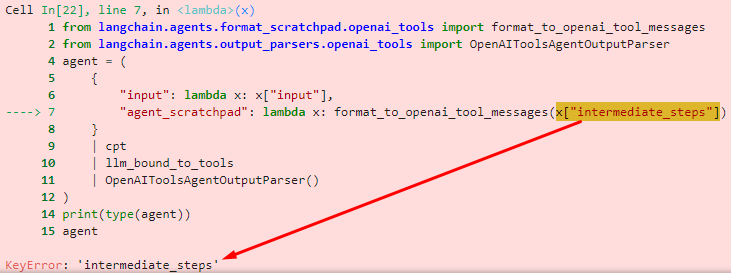

In [14]:
print(f"Recall: the question is <{question_for_tools}>\n")
# agent.invoke({"input": question_for_tools})

Recall: the question is <My name is Mauro. What do I get, if I apply the magic tool to the number of characters of my name?>



#### Wrap the agent into an `AgentExecutor` to let it automatically build and pass the `agent_scratchpad` variable.

In [15]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_executor

AgentExecutor(verbose=True, agent=RunnableMultiActionAgent(runnable={
  input: RunnableLambda(...),
  agent_scratchpad: RunnableLambda(...)
}
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="Your name is Carl, you are very powerful assistant, but don't know current events")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')), MessagesPlaceholder(variable_name='agent_scratchpad')])
| RunnableBinding(bound=AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f363af375d0>, async_client=<op

In [16]:
agent_executor.invoke({"input": question_for_tools})



> Entering new AgentExecutor chain...

Invoking: `magic_tool` with `{'input': 5}`


8If you apply the magic tool to the number of characters in your name, Mauro, which is 5, you get 8.

> Finished chain.


{'input': 'My name is Mauro. What do I get, if I apply the magic tool to the number of characters of my name?',
 'output': 'If you apply the magic tool to the number of characters in your name, Mauro, which is 5, you get 8.'}

In [17]:
list(agent_executor.stream({"input": question_for_tools}))



> Entering new AgentExecutor chain...

Invoking: `magic_tool` with `{'input': 5}`


8If you apply the magic tool to the number of characters in your name, Mauro, which is 5, you get 8.

> Finished chain.


[{'actions': [OpenAIToolAgentAction(tool='magic_tool', tool_input={'input': 5}, log="\nInvoking: `magic_tool` with `{'input': 5}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_4hKJ0QajlbhBTkWsSCxNIY9c', 'function': {'arguments': '{"input":5}', 'name': 'magic_tool'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-87e55a4d-9d75-49ba-8865-2fc89d489342')], tool_call_id='call_4hKJ0QajlbhBTkWsSCxNIY9c')],
  'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_4hKJ0QajlbhBTkWsSCxNIY9c', 'function': {'arguments': '{"input":5}', 'name': 'magic_tool'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-87e55a4d-9d75-49ba-8865-2fc89d489342')]},
 {'steps': [AgentStep(action=OpenAIToolAgentAction(tool='magic_tool', tool_input={'input': 5}, log="\nInvoking: `magic_tool` with `{'input': 5}`\n\n\n", message_log=[AIMessageChunk(cont

# Now let's use the **Tool Calling Agent** agent to get the same result
We can choose among [multiple agents](https://python.langchain.com/docs/modules/agents/agent_types/).<br/>
In this case we choose a [Tool Calling Agent](https://python.langchain.com/docs/modules/agents/agent_types/tool_calling/), defined as ***an Agent that uses Tools***:
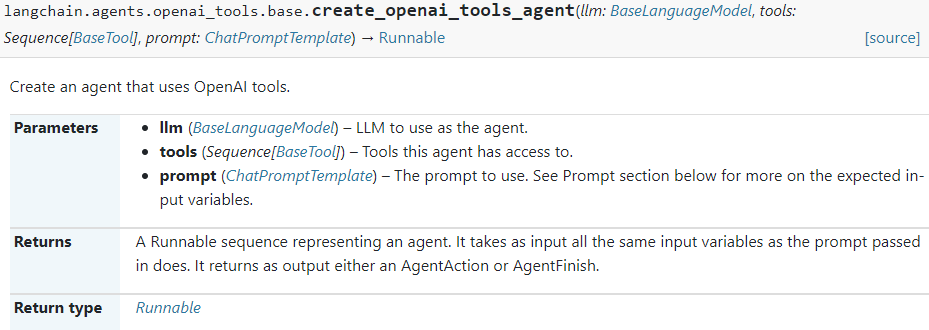

In [18]:
from langchain.agents.openai_tools.base import create_openai_tools_agent

agent = create_openai_tools_agent(
    llm = llm, 
    tools = tools, 
    prompt = cpt)

from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

list(agent_executor.stream({"input": question_for_tools}))



> Entering new AgentExecutor chain...

Invoking: `magic_tool` with `{'input': 5}`


8If you apply the magic tool to the number of characters in your name, Mauro, which is 5, you get 8.

> Finished chain.


[{'actions': [OpenAIToolAgentAction(tool='magic_tool', tool_input={'input': 5}, log="\nInvoking: `magic_tool` with `{'input': 5}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_x2ERTfXmnJwwHiFU39Skzg4d', 'function': {'arguments': '{"input":5}', 'name': 'magic_tool'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-ac4f00c5-e75d-4d5e-acc1-a1b170796c57')], tool_call_id='call_x2ERTfXmnJwwHiFU39Skzg4d')],
  'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_x2ERTfXmnJwwHiFU39Skzg4d', 'function': {'arguments': '{"input":5}', 'name': 'magic_tool'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-ac4f00c5-e75d-4d5e-acc1-a1b170796c57')]},
 {'steps': [AgentStep(action=OpenAIToolAgentAction(tool='magic_tool', tool_input={'input': 5}, log="\nInvoking: `magic_tool` with `{'input': 5}`\n\n\n", message_log=[AIMessageChunk(cont

### Does this agent has memory? No, it doesn't

In [19]:
print(f"question_follow_up: {question_follow_up}")
agent_executor.invoke({"input": question_follow_up})

question_follow_up: Is this result an even or odd number?


> Entering new AgentExecutor chain...
To determine if the result is even or odd, I'll need to know the specific number you're referring to. Could you please provide the number you're asking about?

> Finished chain.


{'input': 'Is this result an even or odd number?',
 'output': "To determine if the result is even or odd, I'll need to know the specific number you're referring to. Could you please provide the number you're asking about?"}

# Adding memory
In order to do this, we need to do these things:
1) Add a place for memory variables to go in the `ChatPromptTemplate` definition
2) Add the `chat_history` element in `agent` definition
3) Re-build the `agent_executor`, based on the new `agent` definition
4) Call the `agent_executor` passing the "first" question (**question_for_tools**) and update the chat_history using the "output" of the returned object
5) Call the `agent_executor` passing the **question_follow_up**

In [20]:
# 1. Add a place for memory variables to go in the ChatPromptTemplate definition
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

MEMORY_KEY = "chat_history"

cpt = ChatPromptTemplate.from_messages(
    [    
        ("system", "Your name is Carl, you are very powerful assistant, but don't know current events"),
        MessagesPlaceholder(variable_name=MEMORY_KEY), # this is the line to keep track of the chat history
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ]
)

In [21]:
# 2. Add the chat_history element in agent definition

from langchain.agents.format_scratchpad.openai_tools import format_to_openai_tool_messages
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(x["intermediate_steps"]),
        MEMORY_KEY: lambda x: x[MEMORY_KEY] # this is the line to keep track of the chat history
    }
    | cpt
    | llm_bound_to_tools
    | OpenAIToolsAgentOutputParser()
)

In [22]:
# 3. Re-build the agent_executor, based on the new agent definition

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [23]:
# 4) Call the `agent_executor` passing the "first question" (question_for_tools) and 
# update the chat_history using the "output" of the returned object

from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

result = agent_executor.invoke({"input": question_for_tools, "chat_history": chat_history})

chat_history.extend(
    [
        HumanMessage(content=question_for_tools),
        AIMessage(content=result["output"]),
    ]
)

chat_history



> Entering new AgentExecutor chain...

Invoking: `magic_tool` with `{'input': 5}`


8If you apply the magic tool to the number of characters in your name, Mauro, which is 5, you get 8.

> Finished chain.


[HumanMessage(content='My name is Mauro. What do I get, if I apply the magic tool to the number of characters of my name?'),
 AIMessage(content='If you apply the magic tool to the number of characters in your name, Mauro, which is 5, you get 8.')]

In [24]:
# 5) Call the `agent_executor` passing the **question_follow_up**
print(f"question_follow_up: {question_follow_up}")

result = agent_executor.invoke({"input": question_follow_up, "chat_history": chat_history})

question_follow_up: Is this result an even or odd number?


> Entering new AgentExecutor chain...
The result, 8, is an even number.

> Finished chain.


In [ ]:
result

# Return the final result as a Node

In [25]:
from langchain_core.messages import HumanMessage

node_name = "my_node"

{"messages": [HumanMessage(content=result["output"], name=node_name)]}

{'messages': [HumanMessage(content='The result, 8, is an even number.', name='my_node')]}

## Helper function to build a node

In [26]:
# This function facilitates creating nodes in the graph:
# it takes care of invoking the agent executor and then converts its response to a human message. 
# That is how we will add it the global state of the graph

def agent_node(state, agent_executor, node_name):
    from langchain_core.messages import HumanMessage
    result = agent_executor.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=node_name)]}

state = {"input": question_follow_up, "chat_history": chat_history}
print(f"Agent state:\n{state}")

agent_executor = agent_executor
node_name = "my_node"

agent_node (state=state, agent_executor=agent_executor, node_name=node_name)

Agent state:
{'input': 'Is this result an even or odd number?', 'chat_history': [HumanMessage(content='My name is Mauro. What do I get, if I apply the magic tool to the number of characters of my name?'), AIMessage(content='If you apply the magic tool to the number of characters in your name, Mauro, which is 5, you get 8.')]}


> Entering new AgentExecutor chain...
The result, 8, is an even number.

> Finished chain.


{'messages': [HumanMessage(content='The result, 8, is an even number.', name='my_node')]}